In [12]:
#Task 1.1
from __future__ import print_function
from ase import Atoms
from ase.units import eV, Ang, GPa
import Morse

d = 2.5*Ang
a = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., d)])
# these parameters are suitable for Cu
# parameters from De Wette et al Physics Letters vol 23 (1966) http://www.sciencedirect.com/science/article/pii/0031916366900138
calc = Morse.MorsePotential(D=0.16156*eV, alpha=2.0926/Ang, r0=2.6163*Ang) 

a.set_calculator(calc) 
a.get_potential_energy()
p = a.get_positions()
p[1,2] = 2.8
a.set_positions(p)
a.get_potential_energy()
f = a.get_forces()
f

array([[ 0.        ,  0.        ,  0.14692478],
       [ 0.        ,  0.        , -0.14692478]])

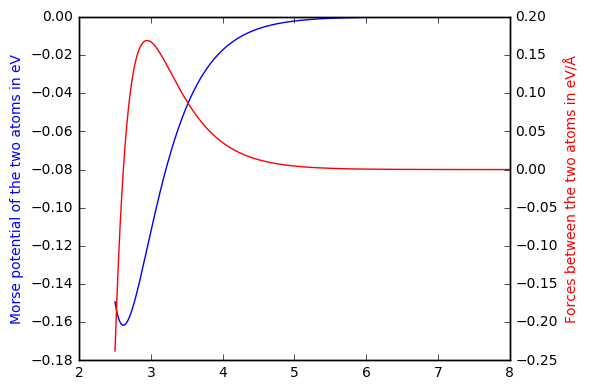

In [85]:
#Deliverable 1.1
from __future__ import print_function
from ase import Atoms
from ase.units import eV, Ang, GPa
import Morse
import matplotlib.pyplot as plt
import numpy as np

#taken from Task 1.1
calc = Morse.MorsePotential(D=0.16156*eV, alpha=2.0926/Ang, r0=2.6163*Ang)
#Array of distances, increasing quadratically, since the force should follow an inverse square law
#the 2.5 - 8 range is typical for lattice constants
dists = np.arange(start = np.sqrt(2.5), stop = np.sqrt(8), step = 0.001)
dists = np.power(dists, 2)

cuPair = Atoms('2Cu', positions=[(0., 0., 0.), (0., 0., 0.)]) #The atom pair
cuPair.set_calculator(calc)

forces = [] #the array to record the forces between the atoms
pots = [] #the array to record the Morse potentials
#Computing the forces and potentials:
for distance in dists:
    pos = cuPair.get_positions()
    pos[1,2] = distance
    cuPair.set_positions(pos)
    forces.append(cuPair.get_forces()[0,2])
    pots.append(cuPair.get_potential_energy())
    #print(distance)
    #print(cuPair.get_forces()[1,2])
    
fig, pots_plot = plt.subplots()
forces_plot = pots_plot.twinx()
forces_plot.plot(dists, forces, 'r')
pots_plot.plot(dists, pots, 'b')
forces_plot.set_xlabel('Distance of the two atoms in ångströms')
forces_plot.set_ylabel('Forces between the two atoms in eV/Å', color='r')
pots_plot.set_ylabel('Morse potential of the two atoms in eV', color='b')
fig.tight_layout()
plt.show()

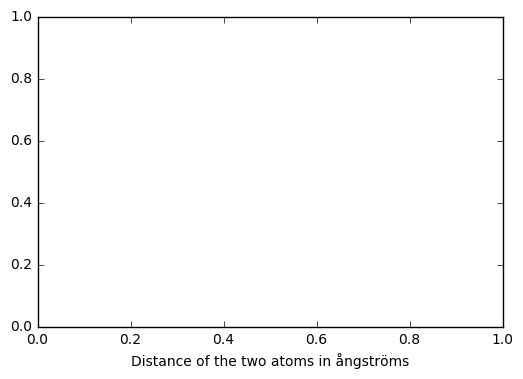

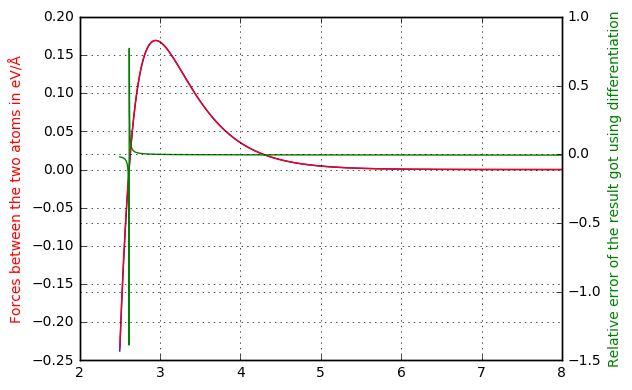

In [134]:
#Deliverable 1.2
#The results of the previous Deliverable are reused

dfs = []
force_diffs = []
for index in range(len(dists)-1):
    dfs.append((pots[index+1]-pots[index])/(dists[index+1]-dists[index]))
    force_diffs.append(dfs[index] - forces[index])

#Plot the results
fig, forceplots = plt.subplots()
forceplots.plot(dists[:-1], forces[:-1], 'b')
forceplots.plot(dists[:-1], dfs, 'r')
plt.grid()
errplot = forceplots.twinx()
errplot.plot(dists[:-1], np.divide(force_diffs, forces[:-1]), 'g')
plt.grid()
fig.tight_layout()
forceplots.set_ylabel('Forces between the two atoms in eV/Å', color='r')
errplot.set_ylabel('Relative error of the result got using differentiation', color='g')
plt.xlabel('Distance of the two atoms in ångströms')
plt.show()